In [1]:
from datetime import date
from scipy import stats
import pandas as pd
import numpy as np
import io
import requests
from sklearn.mixture import GaussianMixture
from plotly.subplots import make_subplots
import plotly.graph_objects as go

Creating two different functions
<ul>
<li> Retrieving the FX Rate from the ECB
<li>Retrieving Number of Gaussian Mixtures
</ul>

In [2]:
def get_fx_rate(currency,start_date,end_date):
    '''
    Retrieving the exchange rate vs EUR from ECB webservice
    Example
    df = get_fx_rate('USD',pd.to_datetime('2010-01-02'),pd.to_datetime('2020-01-01'))
    '''
    try:
        
        # constructing the URL 
        entrypoint = 'https://sdw-wsrest.ecb.europa.eu/service/'
        resource = 'data'
        flow_ref = 'EXR'
        key = f'D.{currency}.EUR.SP00.A'
        date_format = '%Y-%m-%d'
        parameters = {
        'startPeriod': start_date.strftime(date_format),
        'endPeriod': end_date.strftime(date_format)}
        request_url = f'{entrypoint}{resource}/{flow_ref}/{key}'
        
        # send / retrieve data-request
        response = requests.get(request_url, params=parameters, headers={'Accept': 'text/csv'})
        
        # transforming the ooutput into a pandas dataframe
        df = pd.read_csv(io.StringIO(response.text))
        df = df[['TIME_PERIOD','OBS_VALUE']]
        df.set_index('TIME_PERIOD',inplace=True)
        df.columns = [currency]
    except:
        df=None 
    return df 


In [3]:
def get_gm_mixture(df,param):
    '''
    Training Gaussian Mixture Models
    '''
    dg = df.copy()
    dg['ret'] = dg.pct_change(periods=param['periods'])
    dg.dropna(how='any',inplace=True)
    gm = GaussianMixture(n_components=param['nbr_mixtures'], random_state=0).fit(dg['ret'].values.reshape(-1,1))
    ret = dg['ret'].values
    return gm , ret

Making the different Plots

In [4]:
def make_plot(param):
    df = get_fx_rate(param['currency'],param['start_date'],param['end_date'])
    gm , ret = get_gm_mixture(df,param)    
    
    fig = make_subplots(rows=1, cols=2)
    fig.add_trace(
        go.Scatter(x=df.index,
                   y=df[param['currency']],
                   name=param['currency']),
        row=1, col=1)
    
    xrange = np.arange(min(ret),max(ret),0.001)
    for i in np.arange(0,param['nbr_mixtures']):
        density_plot = go.Scatter(x=xrange*100,
                                  y=stats.norm(loc=gm.means_[i][0], 
                                               scale=np.sqrt(gm.covariances_[i][0][0])).pdf(xrange), 
                                  mode='lines',
                                  line=dict(width=1.5),
                                  name='Mean= '+ str(np.round(gm.means_[i][0]*100,2))+' %')
        fig.add_trace(density_plot,row=1,col=2)

    
    fig.update_layout(height=600, width=800, title_text=param['currency'])
    
    return fig

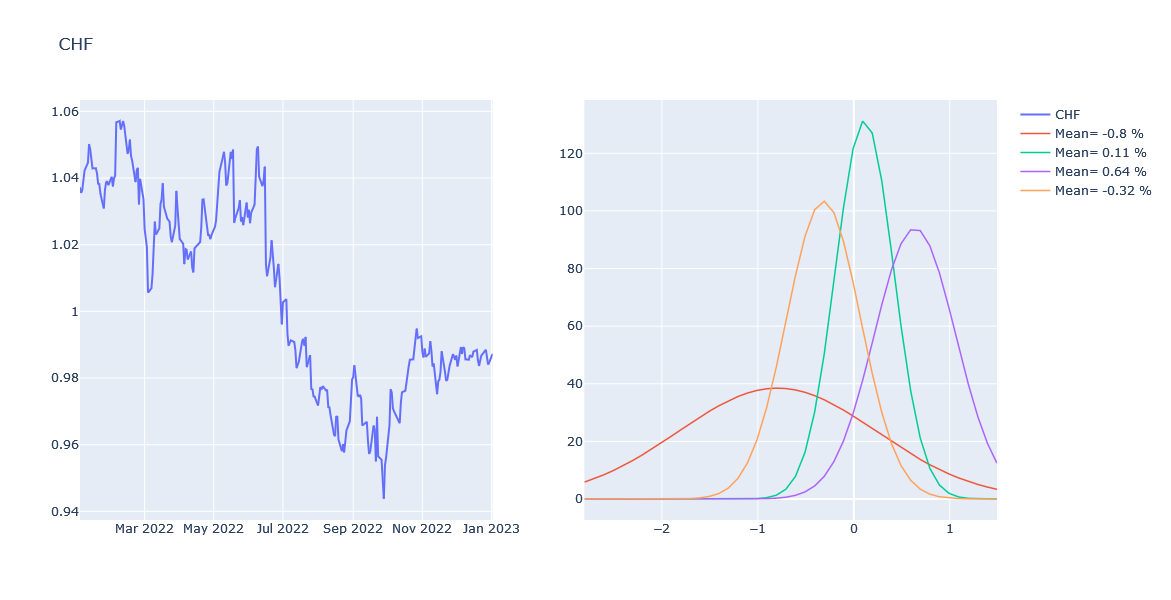

In [7]:
param = {}
param['periods']=1
param['nbr_mixtures']=4
param['currency'] = 'CHF'
param['start_date'] = pd.to_datetime('2022-01-02')
param['end_date'] =  pd.to_datetime('2023-01-02')


figure = make_plot(param)
figure.show()